In [104]:
!pip install pennylane nftopt

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of qcs-api-client to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of qcs-api-client to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60

## Importing Libraries

In [68]:
import pennylane as qml
import math
import numpy as np
from scipy.linalg import block_diag
from scipy import optimize
# from nftopt import nakanishi_fujii_todo as nftmethod
# from qiskit import QuantumCircuit
# import qiskit.quantum_info as qi
from scipy.linalg import expm, norm
import matplotlib.pyplot as plt
import numpy as np

## First trying to prepare the initial state

### Since our initial state contains all positive values, we'll use approach 1, which uses no ancillary qubits

In [180]:
# defing parameters
n_qubits = 3
wires=[i for i in range(n_qubits)]
# lower depth works for our qubits
depth = 4

In [181]:
dev = qml.device("default.qubit", wires = wires)

In [182]:
# Set parameters, defining the initial state
delta = 1.0
Omega = 1.0
gamma = 1.0
Delta_t = 0.01
alpha=np.sqrt(2)/2*delta*Delta_t;
beta=(1-gamma*Delta_t/2);

# defining normalized state vector x 
aa=[Delta_t*np.sqrt(2)/2*delta,Delta_t*gamma/4,np.sqrt(alpha**2+beta**2),Delta_t*gamma/4,Delta_t*gamma/4,Delta_t*gamma/4,Delta_t*gamma/4,Delta_t*gamma/4]
x=np.sqrt(aa);
norma=np.linalg.norm(x);
x=x/np.linalg.norm(x);

In [183]:
# Exact vector a
alpha = np.sqrt(2)/2*delta*Delta_t
beta = (1-gamma*Delta_t/2)

#### Defining functions needed for the preparation

In [184]:
def accuracy(labels, predictions):
  state0 = qml.math.dm_from_state_vector(labels)
  state1 = qml.math.dm_from_state_vector(predictions)
  return qml.math.fidelity(state0, state1)

In [192]:
def ansatz_layer_Ua(layer_weights, depth=depth, n_qubits=n_qubits):
    # using the efficient SU2 ansatz, since that provided better performance than author's ansatz
    # cntr=0
    # for dep in range(depth):
    #     for i in range(n_qubits):
    #       qml.RY(layer_weights[cntr],i)
    #       qml.RZ(layer_weights[cntr+1],i)
    #       cntr+=2
    #     for k in range(n_qubits):
    #         for j in range(k+1,n_qubits):
    #             qml.CNOT(wires=[k, j])
    # for i in range(n_qubits):
    #   qml.RY(layer_weights[cntr],i)
    #   qml.RZ(layer_weights[cntr+1],i)
    #   cntr+=2

    #using the random gate structure with C PhaseFlip gates
    cntr= 0
    for dep in range(depth):
         for i in range(n_qubits):
            match gate_decider[cntr]:
                case 0:
                    qml.RX(layer_weights[cntr],i)
                case 1:
                    qml.RY(layer_weights[cntr],i)
                case 2:
                    qml.RZ(layer_weights[cntr],i)
            cntr+=1
            if i+1 != n_qubits:
                qml.CZ(wires=[i,i+1])

In [186]:
@qml.qnode(dev,diff_method="backprop")
def circuit(weights):
  # since depth 4 was used
  ansatz_layer_Ua(weights,depth=depth, n_qubits=n_qubits)
  # qml.state() applies Ua to Ini State, which gives Appro_a
  return qml.state()

In [187]:
def variational_classifier(weights, x):
    # weights are thetas
    return np.real(circuit(weights))

##### Defining the loss function

In [188]:
def F1_loss(a,Appro_a, thetas):
  global max_cost
  #   Define the cost function
  F1=(a[0]**2)*np.log2((Appro_a[0]**2)/(a[0]**2))+(a[1]**2)*np.log2((Appro_a[1]**2)/(a[1]**2))+(a[2]**2)*np.log2((Appro_a[2]**2)/(a[2]**2))
  F2=(a[3]**2)*np.log2((Appro_a[3]**2)/(a[3]**2))+(a[4]**2)*np.log2((Appro_a[4]**2)/(a[4]**2))+(a[5]**2)*np.log2((Appro_a[5]**2)/(a[5]**2))
  F3=(a[6]**2)*np.log2((Appro_a[6]**2)/(a[6]**2))+(a[7]**2)*np.log2((Appro_a[7]**2)/(a[7]**2))

  #   Prepare the Bell state
  Bell_State=np.ones((8,1))/np.linalg.norm(np.ones((8,1)))
  #   The sum of vector a
  Sum_a=np.sum(a)
  sqrt_D = np.linalg.norm(np.ones((8,1)))
  UaFunction=np.abs(Sum_a -  (sqrt_D * np.matmul(np.transpose(Bell_State), Appro_a)))-(F1+F2+F3)
  if UaFunction < max_cost-0.01:
      max_cost=UaFunction
      print(max_cost)
  # theta_print_factor=0.01
  # if max_cost < theta_print_factor:
  #     print(thetas)
  return np.real(UaFunction)

In [189]:
def cost(weights, X=x):
    # X is our preparation state, Appro_a is our approximation
    Appro_a = variational_classifier(weights, X)
    return F1_loss(X, Appro_a, weights)

In [195]:
# printing the cost, just to see effectiveness of minimize methods
max_cost= 1
# for deciding random circuits
param_num = n_qubits*depth
gate_decider = np.random.randint(3, size=param_num)
weights=4*np.pi*np.random.rand(param_num)
bounds = [(0, 4*np.pi)]*len(weights)
result= optimize.differential_evolution(cost, bounds,maxiter=2000, x0=weights, mutation=(0.5,1.2),popsize=20, workers=-1, tol=1e-3)#optimize.dual_annealing(cost, bounds,maxiter=300, x0=weights,initial_temp=10**4)

[0.89936703]
[0.83320752]
[0.83079092]
[0.91021543]
[0.87585324]
[0.79797818]
[0.87481594]
[0.80195829]
[0.75398214]
[0.79893177]
[0.9715419]
[0.74568955]
[0.83253996]
[0.98937017]
[0.85371109]
[0.49929271][0.92455386]
[0.78573877]

[0.84933444]
[0.84970856]
[0.8394239]
[0.63283492]
[0.74758515]
[0.75919417]
[0.47239823]
[0.91684264]
[0.83920656]
[0.82643499]
[0.60673807]
[0.89762797]
[0.98700973]
[0.92637254]
[0.5837372]
[0.91711809]
[0.8865757]
[0.60620683]
[0.70121376]
[0.77146713]
[0.77194064]
[0.97814374]
[0.63322152][0.9802608]

[0.840717]
[0.51690847]
[0.70642398]
[0.9099772]
[0.91479578]
[0.79560345]
[0.85757436]
[0.73393328]
[0.7728514]
[0.84131406]
[0.83336779]
[0.69782226]
[0.82100048]
[0.96102385]
[0.90163139]
[0.70010319]
[0.61336175]
[0.98722295]
[0.82067701]
[0.6483149]
[0.98260026]
[0.7442937]
[0.69896261]
[0.87649593]
[0.66753431]
[0.8803118]
[0.96134564]
[0.90945399]
[0.90385527]
[0.92909078][0.66921072]

[0.79773814]
[0.51146815]
[0.66748285]
[0.70733483]
[0.75853901

In [84]:
print(result.x)

[ 3.30878217  6.98384882  6.06375519  2.33229351  2.54408835  9.17930314
  0.19086799 10.67248359  1.29418114  1.16329476  3.15607829  6.51101469
  9.23705349  4.57354318 11.03925065  1.19358174  5.8770505   3.56503638
  9.45871296  9.33999659  7.55102784  4.48873571  1.72465797  4.9100174
  9.38889579 10.26104615  9.35028035 11.56169551  4.19650682  3.13755318]


#### Printing the accuracy

In [85]:
predictions=variational_classifier(result.x,x)
acc = accuracy(x, predictions)
print(predictions.numpy(), x)
acc

[ 0.10018887  0.06709122  0.98350083 -0.03663443  0.06353929  0.06513062
  0.06685325  0.0602687 ] [0.08337992 0.049578   0.98909045 0.049578   0.049578   0.049578
 0.049578   0.049578  ]


0.9906552950789766

In [86]:
# since we wanted to keep this file clean, we avoided running it all over again
Appro_a=predictions.numpy()

#### Getting the Unitary operator for preparing the Initial State

In [87]:
# getting a
#based on the formulation of the paper
Ua_matrix = qml.matrix(ansatz_layer_Ua, wire_order=wires)

Ua_theta_opt = np.matrix(Ua_matrix(result.x))

## Preparation of evolution unitary operator

### Getting the actual unitary

In [30]:
# Pauli operators
I = np.eye(2)
X = np.array([[0,1],[1,0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])
Hadamard = np.array([[1, 1], [1, -1]]) / np.sqrt(2)

In [31]:
# The non-Hermitian operator H

H0 = np.kron(I,1j*Hadamard)
H1 = np.kron(I,-Z)
H2 = np.kron((-1j * alpha * Hadamard + beta * I) / np.sqrt(alpha**2 + beta**2), I)
H3 = np.kron(-Z,I)
H4 = np.kron(X,X)
H5 = np.kron(X,-1j*Y)
H6 = np.kron(-1j*Y,X)
H7 = np.kron(-Y,Y)

In [32]:
# The non-Hermitian operator Q

I_4 = np.eye(4)

Q0 = I_4 + Delta_t*H0
Q1 = I_4 + Delta_t*H1
Q2 = I_4 + Delta_t*H2
Q3 = I_4 + Delta_t*H3
Q4 = I_4 + Delta_t*H4
Q5 = I_4 + Delta_t*H5
Q6 = I_4 + Delta_t*H6
Q7 = I_4 + Delta_t*H7
Q_i = np.array([Q0,Q1,Q2,Q3,Q4,Q5,Q6,Q7])

In [33]:
Q =0
for i in range(len(aa)):
    Q+= aa[i]*Q_i

In [34]:
# unitary checker
def is_unitary(m):
    return np.allclose(np.eye(m.shape[0]), m.H * m)

In [35]:
# Multi-controlled unitary
Lambda_Q_actual = np.asmatrix(block_diag(Q0, Q1, Q2, Q3, Q4, Q5, Q6, Q7))

print(Lambda_Q_actual)
print(is_unitary(Lambda_Q_actual))

[[ 1.  +0.00707107j  0.  +0.00707107j  0.  +0.j         ...
   0.  +0.j          0.  +0.j          0.  +0.j        ]
 [ 0.  +0.00707107j  1.  -0.00707107j  0.  +0.j         ...
   0.  +0.j          0.  +0.j          0.  +0.j        ]
 [ 0.  +0.j          0.  +0.j          1.  +0.00707107j ...
   0.  +0.j          0.  +0.j          0.  +0.j        ]
 ...
 [ 0.  +0.j          0.  +0.j          0.  +0.j         ...
   1.  +0.j         -0.01+0.j          0.  +0.j        ]
 [ 0.  +0.j          0.  +0.j          0.  +0.j         ...
  -0.01+0.j          1.  +0.j          0.  +0.j        ]
 [ 0.  +0.j          0.  +0.j          0.  +0.j         ...
   0.  +0.j          0.  +0.j          1.  +0.j        ]]
False


### The circuit and optimization configuration

In [260]:
# defing parameters
n_qubits = 5
wires=[i for i in range(n_qubits)]
# lower depth works for our qubits
depth = 10

In [261]:
# @qml.qnode(dev,diff_method="backprop")
def circuit(weights):
  # returning the matrix itself, since it'll be the component needed for simulation
  return Uq_theta(weights)

In [262]:
def accuracy__unitary_matrices(u1, u2):
    #qml.HilbertSchmidt
  state0 = qml.math.dm_from_state_vector(labels)
  state1 = qml.math.dm_from_state_vector(predictions)
  return qml.math.fidelity(state0, state1)

In [263]:
dev = qml.device("default.qubit",wires=wires)
dev

<default.qubit device (wires=5) at 0x7f827a48cf40>

In [264]:
def variational_classifier(weights):
    # weights are thetas
    # np.real(Ua|0>)
    return circuit(weights)

In [265]:
def g_beta_loss(Uq_theta):

  UqFunction = np.abs(1-1/(32**2) * np.trace(np.matmul(Uq_theta.H,Lambda_Q_actual))**2)
  return UqFunction


In [266]:
def cost(weights):
    # X is our preparation state
    Uq_theta = variational_classifier(weights)
    return g_beta_loss(Uq_theta)

In [267]:
#UqLay
def ansatz_layer_Uq(layer_weights,depth=depth, n_qubits=n_qubits):
    # cntr = 0
    # for dep in range(depth):
    #     for wire in range(n_qubits):
    #       qml.RZ(layer_weights[cntr+wire], wires = wire)
    #       qml.RY(layer_weights[cntr+wire+n_qubits], wires = wire)
    #       qml.RZ(layer_weights[cntr+wire+2*n_qubits], wires = wire)
    #     cntr += 15
    #     qml.CRY(layer_weights[cntr], wires = [0,1])
    #     qml.CRY(layer_weights[cntr+1], wires = [2,3])
    #     qml.CRY(layer_weights[cntr+2], wires = [1,2])
    #     qml.CRY(layer_weights[cntr+3], wires = [3,4])
    #     qml.CRY(layer_weights[cntr+4], wires = [4,0])
    #     cntr+=5
    #Using Efficient SU2 provided much better results with lower depth
    # cntr=0
    # for dep in range(depth):
    #     for i in range(n_qubits):
    #       qml.RY(layer_weights[cntr],i)
    #       qml.RZ(layer_weights[cntr+1],i)
    #       cntr+=2
    #     for k in range(n_qubits):
    #         for j in range(k+1,n_qubits):
    #             qml.CNOT(wires=[k, j])
    # for i in range(n_qubits):
    #   qml.RY(layer_weights[cntr],i)
    #   qml.RZ(layer_weights[cntr+1],i)
    #   cntr+=2

    # # random unitary results in fastest convergence, logical framework
    cntr= 0
    for dep in range(depth):
         for i in range(n_qubits):
            match gate_decider[cntr]:
                case 0:
                    qml.RX(layer_weights[cntr],i)
                case 1:
                    qml.RY(layer_weights[cntr],i)
                case 2:
                    qml.RZ(layer_weights[cntr],i)
            cntr+=1
            if i+1 != n_qubits:
                qml.CZ(wires=[i,i+1])
                
def ansatz_layer_Uq_qiskit(layer_weights,depth=depth, n_qubits=n_qubits):
    cntr = 0
    qc=QuantumCircuit(n_qubits)
    for dep in range(depth):
        for wire in range(n_qubits):
          qc.rz(layer_weights[cntr+wire],  wire)
          qc.ry(layer_weights[cntr+wire+n_qubits], wire)
          qc.rz(layer_weights[cntr+wire+(2*n_qubits)], wire)
        cntr += (3*n_qubits)

        qc.cry(layer_weights[cntr],  0,1)
        qc.cry(layer_weights[cntr+1],1,2)
        qc.cry(layer_weights[cntr+2], 2,3)
        qc.cry(layer_weights[cntr+3], 3,4)
        qc.cry(layer_weights[cntr+4],4,0)
        cntr+=5
    return qc


In [268]:
#no of params
gate_decider = np.random.randint(3, size=param_num)
param_num = (n_qubits)*depth#depth*(3*n_qubits + 5)
weights = 4*np.pi*np.random.rand(param_num)
Uq_theta = qml.matrix(ansatz_layer_Uq, wire_order=wires)
# mat= qml.matrix(ansatz_layer, wire_order=wires)
# mat(weights)

In [318]:
# result= optimize.differential_evolution(cost,weights, method=nftmethod, options={'maxfev':10024})
"""Since running this requires a lot of time because of huge number of parameters, we have used the 
Uq matrix computed from our earlier simulation where we had used the random gate configuaration with CPhase flip gates, we
result.fun=1e-6
"""

Lambda_Q=np.asmatrix(Uq_theta(np.array([ 5.33737125,  8.25781812,  9.47067565,  0.63426178,  2.72262396,
       11.43083309,  2.98240673,  6.19901819,  3.67142375,  2.31424128,
        6.27329224,  5.10920449,  2.38272196, 10.14531661,  7.89559017,
       11.55791786,  7.4724418 ,  8.84451533, 11.57312007,  3.18134265,
        2.98633586,  4.5405008 ,  6.24543523,  5.56273977,  2.71928707,
       12.56877596, 10.21007478,  2.88312078,  1.53550569,  0.74682235,
        3.14212126,  4.87801661,  6.27176622,  3.13828776, 11.84375966,
        0.20540738,  8.72411719,  9.42692602,  5.29301087,  1.62740387,
        8.62711677,  3.13673716,  7.74366438, 12.3791118 ,  9.28185859,
        6.24703898, 11.3714098 ,  6.29434697,  0.60730553,  0.79115804])))

In [285]:
# Lambda_Q=np.asmatrix(Uq_theta(params))
print(is_unitary(Lambda_Q))

True


In [287]:
# measuring the fidelity

1-np.sum(np.abs(Lambda_Q_actual - Lambda_Q ))/(len(Lambda_Q)**2)
# Lambda_Q = Lambda_Q_actual

0.8538931972297111

## Simulations Part

In [301]:
zero = np.array([1,0])
I = np.identity(2)
X = np.array([[0,1],[1,0]])

In [302]:
Vec_Rho_Ini = np.kron(zero, zero)
# Lambda_Q@np.kron(Appro_a, Rho_t)

In [303]:
Hat_M = np.kron(I,X)

In [304]:
# Strategy B
I_three = np.asmatrix(np.kron(zero, np.kron(zero, zero))).T
Widetilde_M = np.kron(I_three@ I_three.H, Hat_M)
Widetilde_I = np.kron(I_three@ I_three.H, np.kron(I,I))

# Bell state
Bell_state = np.asmatrix(np.sqrt(2)*np.array([1,0,0,1])).T

In [306]:

Number = 500
Delta_t = 0.01

Simu_Expectation = np.zeros(Number)
Exact_Expectation = np.zeros(Number)
First_Expectation = np.zeros(Number)
Pro = np.zeros(Number)
ExactTrace = np.zeros(Number)
Iteration=[]

In [307]:

Rho_t = Vec_Rho_Ini
Exact_Rho_t = Vec_Rho_Ini
First_Rho_t = Vec_Rho_Ini
print(Rho_t)

[1 0 0 0]


In [308]:
H=-delta/2*Z-Omega/2*X;
L=np.sqrt(gamma)/2*(X-1j*Y);

In [309]:
Hat_L1=np.kron(np.conj(L),L)-1/2*np.kron(I,(L.T)@L)-1/2*np.kron((L.T)@np.conj(L),I);
Hat_H=-1j*(np.kron(I,H)-np.kron((H.T),I))+Hat_L1;
First_operator=np.kron(I,I)+Hat_H*Delta_t;
Error_HQ=First_operator-Q

In [310]:
Rho_t = Vec_Rho_Ini
Exact_Rho_t = Vec_Rho_Ini
First_Rho_t = Vec_Rho_Ini
for i in range(Number):
    Iteration.append((i+1)*Delta_t)

    Rho_t = Lambda_Q@(np.kron(Appro_a, Rho_t))
    Rho_t = np.kron(Ua_theta_opt.H,np.kron(I,I)) @ Rho_t.T
    # Measurement
    PI = I_three@ I_three.H
    PI = np.kron(PI, np.kron(I,I))
    Rho_t = PI@Rho_t
    Pro[i]= (np.linalg.norm(Rho_t)**2)
    Rho_t = Rho_t/np.linalg.norm(Rho_t)
    Rho_t = Rho_t[:4].A1

    Simu_Trace = np.real(Bell_state.H @ Rho_t)
    Simu_Expectation_M = np.real(np.dot(np.dot(Bell_state.H, Hat_M), Rho_t))
    Simu_Expectation[i] = np.real(Simu_Expectation_M)/Simu_Trace

    First_Rho_t = np.dot(First_operator, First_Rho_t)
    First_Rho_t = First_Rho_t/norm(First_Rho_t)

    First_Trace = np.real(np.dot(Bell_state.H, First_Rho_t))
    First_Exception_M = np.real(np.dot(np.dot(Bell_state.H, Hat_M),First_Rho_t))
    First_Expectation[i] = First_Exception_M/First_Trace

    Exact_Rho_t = np.dot(expm(Hat_H*Delta_t),Exact_Rho_t)
    ExactTrace[i] = np.sqrt(2)*np.real(Bell_state.H @ Exact_Rho_t)
    Exact_Rho_t = Exact_Rho_t/norm(Exact_Rho_t)
    Exact_Trace = np.real(np.dot(Bell_state.H, Exact_Rho_t))
    Exact_Expectation_M = np.real(np.dot(np.dot(Bell_state.H,Hat_M),Exact_Rho_t))
    Exact_Expectation[i] = Exact_Expectation_M/Exact_Trace

    ExactTrace[i] = (np.real(np.dot(Bell_state.H, Exact_Rho_t)) - 1) / 2

/tmp/ipykernel_105/12199506.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Simu_Expectation[i] = np.real(Simu_Expectation_M)/Simu_Trace
/tmp/ipykernel_105/12199506.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  First_Expectation[i] = First_Exception_M/First_Trace
/tmp/ipykernel_105/12199506.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ExactTrace[i] = np.sqrt(2)*np.real(Bell_state.H @ Exact_Rho_t)
/tmp/ipykernel_105/12199506.py:33: DeprecationWar

In [311]:
Rho_t

array([ 0.22694794+0.35558394j, -0.4526308 -0.19991568j,
       -0.10829349+0.54101477j,  0.49705587-0.16038945j])

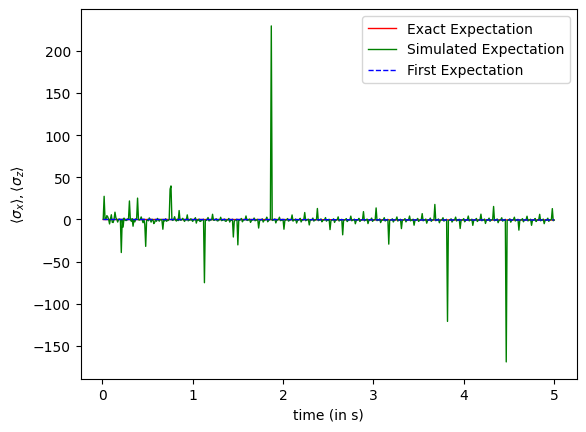

In [317]:
STEP=1
fig=plt.figure()
plt.plot(Iteration[::STEP], Exact_Expectation[::STEP], 'r-', linewidth=1, markersize=4, markeredgecolor='r', markerfacecolor='r', label='Exact Expectation')
plt.plot(Iteration[::STEP], Simu_Expectation[::STEP], 'g', linewidth=1, markersize=4, markeredgecolor='g', markerfacecolor='g', label='Simulated Expectation')
plt.plot(Iteration[::STEP], First_Expectation[::STEP], 'b--', linewidth=1, markersize=4, markeredgecolor='b', markerfacecolor='b',label='First Expectation')
plt.ylabel(r'$\langle\sigma_x\rangle,\langle\sigma_z\rangle$')
plt.xlabel('time (in s)')
plt.legend()
plt.show()

In [314]:
fig.savefig('open_system_diff_d_10', dpi=fig.dpi)